In [1]:
import os
import xarray as xr
import xesmf as xe
import numpy as np
import pandas as pd
import geopandas as gpd
import xagg as xa
import regionmask
import sys
import warnings
warnings.filterwarnings("ignore")


tws_product = 'grace-csr'
agg = 'county'

root_dir = '/dartfs-hpc/rc/lab/C/CMIG'
project_dir = os.path.join(root_dir,'damages','county')
grace_gf_dir = os.path.join(project_dir,'data','interim','grace_gapfilled')

grace_file = os.path.join(grace_gf_dir,f'{tws_product}.nc')

grace_twsa = xr.open_dataset(grace_file)
grace_twsa = grace_twsa[list(grace_twsa.data_vars)[0]].sel(lat=slice(23,51),lon=slice(-126,-66)).sel(time=slice("2003","2024"))
grace_twsa.name = 'twsa'
grace_def = grace_twsa.max("time")-grace_twsa.shift(time=1)

ERROR 1: PROJ: proj_create_from_database: Open of /dartfs-hpc/rc/home/0/f004260/.conda/envs/arg24/share/proj failed


In [2]:
grace_twsa = grace_twsa.sel(time=slice("2003","2024"))

In [3]:
gdf = gpd.read_file(os.path.join(project_dir,'data','interim','cnty_bnds_fixed'))
regions = regionmask.from_geopandas(gdf[['county','geometry']],numbers='county',name='county')
mask = regions.mask_3D_frac_approx(grace_twsa)
mask.name='county'
weights = np.cos(np.deg2rad(mask.lat))


In [4]:
def to_percentile(ts):
    ts_nona = ts[~np.isnan(ts)]
    return np.array([(x>=ts_noa).mean() if not np.isnan(x) else np.nan for x in ts])

In [138]:
def bin_data(ts,bins=bins):
    return np.histogram(ts,bins)[0]

In [141]:
twsa_bins = xr.apply_ufunc(bin_data,
                           grace_twsa.groupby("time.year"),
                           input_core_dims=[['time']],
                           output_core_dims=[['bin']],
                           vectorize=True)

In [192]:
twsa_std_bins = xr.apply_ufunc(bin_data,
                           grace_anom.groupby("time.year"),
                           input_core_dims=[['time']],
                           output_core_dims=[['bin']],
                               kwargs=dict(bins=np.arange(-5,5.1,0.5)),
                           vectorize=True)

In [193]:
twsa_std_bins['bin'] = np.arange(-5,5.1,0.5)[:-1]
twsa_bins['bin'] = bins[:-1]

In [149]:
twsa_bins_cnty = twsa_bins.weighted(mask*weights).mean(['lat','lon'])
twsa_bins_cnty = twsa_bins_cnty.rename({"region":"county"})


In [194]:
twsa_std_bins_cnty = twsa_std_bins.weighted(mask*weights).mean(['lat','lon'])
twsa_std_bins_cnty = twsa_std_bins_cnty.rename({"region":"county"})


In [196]:
std_bin_df

twsa
year bin  county      
2003 -5.0 1001     0.0
          1003     0.0
          1005     0.0
          1007     0.0
          1009     0.0
...                ...
2024  4.5 56037    0.0
          56039    0.0
          56041    0.0
          56043    0.0
          56045    0.0

[1355200 rows x 1 columns]

In [204]:
std_bin_df = twsa_std_bins_cnty.drop(['abbrevs','names']).to_dataframe()
std_bin_df_wide = std_bin_df.pivot_table(index=['county','year'],columns='bin',values='twsa')
std_bin_df_wide.columns = [f'mon_{str(c).replace("-","neg").replace(".","p")}' for c in std_bin_df_wide.columns]

In [162]:
bin_df = twsa_bins_cnty.drop(['abbrevs','names']).to_dataframe()
bin_df_wide = bin_df.pivot_table(index=['county','year'],columns='bin',values='twsa')
bin_df_wide.columns = [f'mon_{str(c).replace("-","neg")}' for c in bin_df_wide.columns]

mon_neg1000  mon_neg400  mon_neg350  mon_neg300  mon_neg250  \
county year                                                                
1001   2003          0.0         0.0         0.0         0.0    0.000000   
       2004          0.0         0.0         0.0         0.0    0.000000   
       2005          0.0         0.0         0.0         0.0    0.000000   
       2006          0.0         0.0         0.0         0.0    0.000000   
       2007          0.0         0.0         0.0         0.0    0.894091   
...                  ...         ...         ...         ...         ...   
56045  2020          0.0         0.0         0.0         0.0    0.000000   
       2021          0.0         0.0         0.0         0.0    0.000000   
       2022          0.0         0.0         0.0         0.0    0.000000   
       2023          0.0         0.0         0.0         0.0    0.000000   
       2024          0.0         0.0         0.0         0.0    0.000000   

             mon_neg200  mon_neg150  mon_neg100  mon_neg50     mon_0  \
county year                                                            
1001   2003         0.0    0.000000    0.000000   0.105909  2.894091   
       2004         0.0    0.000000    0.000000   2.000000  2.105909   
       2005         0.0    0.000000    1.000000   2.000000  2.000000   
       2006         1.0    3.000000    3.000000   0.000000  1.105909   
       2007         5.0    1.105909    0.894091   0.105909  2.894091   
...                 ...         ...         ...        ...       ...   
56045  2020         0.0    0.000000    0.000000   0.136006  1.998211   
       2021         0.0    0.000000    0.000000   0.425348  5.955982   
       2022         0.0    0.000000    0.343744   2.687508  4.111087   
       2023         0.0    0.000000    0.027201   0.976850  1.398146   
       2024         0.0    0.000000    0.081604   2.188639  2.899297   

               mon_50   mon_100   mon_150   mon_200   mon_250   mon_300  \
county year                                                               
1001   2003  3.000000  1.317728  4.682272  0.000000  0.000000  0.000000   
       2004  4.105909  2.788181  1.000000  0.000000  0.000000  0.000000   
       2005  0.105909  4.894091  1.000000  1.000000  0.000000  0.000000   
       2006  1.894091  2.000000  0.000000  0.000000  0.000000  0.000000   
       2007  1.105909  0.000000  0.000000  0.000000  0.000000  0.000000   
...               ...       ...       ...       ...       ...       ...   
56045  2020  2.243062  1.788211  0.521999  3.079834  2.182326  0.050351   
       2021  4.096652  1.421317  0.100703  0.000000  0.000000  0.000000   
       2022  3.073501  1.683457  0.100703  0.000000  0.000000  0.000000   
       2023  6.589087  2.147003  0.811361  0.050351  0.000000  0.000000   
       2024  3.000000  2.308441  1.522019  0.000000  0.000000  0.000000   

             mon_350  mon_400  
county year                    
1001   2003      0.0      0.0  
       2004      0.0      0.0  
       2005      0.0      0.0  
       2006      0.0      0.0  
       2007      0.0      0.0  
...              ...      ...  
56045  2020      0.0      0.0  
       2021      0.0      0.0  
       2022      0.0      0.0  
       2023      0.0      0.0  
       2024      0.0      0.0  

[67760 rows x 18 columns]

In [93]:

grace_ann_mean = grace_twsa.groupby("time.year").mean()
grace_ann_sum = grace_twsa.groupby("time.year").sum(min_count=12)
grace_ann_min = grace_twsa.groupby("time.year").min()
grace_ann_max = grace_twsa.groupby("time.year").max()

grace_ann_mean_cnty = grace_ann_mean.weighted(mask*weights).mean(['lat','lon'])
grace_ann_sum_cnty = grace_ann_sum.weighted(mask*weights).mean(['lat','lon'])
grace_ann_min_cnty = grace_ann_min.weighted(mask*weights).mean(['lat','lon'])
grace_ann_max_cnty = grace_ann_max.weighted(mask*weights).mean(['lat','lon'])

grace_ann_max_cnty.name = 'twsa_max'
grace_ann_min_cnty.name = 'twsa_min'
grace_ann_mean_cnty.name = 'twsa_mean'
grace_ann_sum_cnty.name = 'twsa_sum'

In [95]:
grace_anom = grace_twsa.groupby("time.month").apply(lambda g: (g-g.mean("time"))/g.std("time"))

grace_anom_ann_mean = grace_anom.groupby("time.year").mean()
grace_anom_ann_sum = grace_anom.groupby("time.year").sum(min_count=12)
grace_anom_ann_min = grace_anom.groupby("time.year").min()
grace_anom_ann_max = grace_anom.groupby("time.year").max()

grace_anom_ann_mean_cnty = grace_anom_ann_mean.weighted(mask*weights).mean(['lat','lon'])
grace_anom_ann_sum_cnty = grace_anom_ann_sum.weighted(mask*weights).mean(['lat','lon'])
grace_anom_ann_min_cnty = grace_anom_ann_min.weighted(mask*weights).mean(['lat','lon'])
grace_anom_ann_max_cnty = grace_anom_ann_max.weighted(mask*weights).mean(['lat','lon'])

grace_anom_ann_max_cnty.name = 'twsa_std_max'
grace_anom_ann_min_cnty.name = 'twsa_std_min'
grace_anom_ann_mean_cnty.name = 'twsa_std_mean'
grace_anom_ann_sum_cnty.name = 'twsa_std_sum'



In [96]:
grace_ds = xr.merge([grace_ann_max_cnty,
                     grace_ann_min_cnty,
                     grace_ann_mean_cnty,
                     grace_ann_sum_cnty,
                     grace_anom_ann_max_cnty,
                     grace_anom_ann_min_cnty,
                     grace_anom_ann_mean_cnty,
                     grace_anom_ann_sum_cnty])
grace_ds = grace_ds.rename({"region":"county"})

for v in list(grace_ds.data_vars):
    grace_ds[f'{v}_sq'] = np.power(grace_ds[v],2)
for v in list(grace_ds.data_vars):
    grace_ds[f'{v}_lag1'] = grace_ds[v].shift(year=1)   

In [14]:
cnty_gdp = pd.read_csv(os.path.join(project_dir,'data','raw','econ','us_county_gdp_2001-2024.csv'), encoding="latin1")
cnty_gdp = cnty_gdp[cnty_gdp['Description']=='Real GDP (thousands of chained 2017 dollars) ']
cnty_gdp_long = cnty_gdp.melt(id_vars=['GeoFIPS','GeoName'],value_vars=[str(y) for y in np.arange(2001,2025)],var_name='year',value_name='gdp')
cnty_gdp_long = cnty_gdp_long[cnty_gdp_long['GeoName'].str.contains(",")]
cnty_gdp_long['GeoFIPS'] = cnty_gdp_long['GeoFIPS'].apply(lambda s: int(s.replace('"','')))
cnty_gdp_long['gdp'] = cnty_gdp_long['gdp'].replace({"(NA)":np.nan})
cnty_gdp_long['gdp'] = 1e3*cnty_gdp_long['gdp'].astype(float)
cnty_gdp_long['year'] = cnty_gdp_long['year'].astype(int)

cnty_sum = pd.read_csv(os.path.join(project_dir,'data','raw','econ','us_county_income_1969-2024.csv'), encoding="latin1")
cnty_pop = cnty_sum[cnty_sum['Description']==' Population (persons) 3/']
cnty_pop_long = cnty_pop.melt(id_vars=['GeoFIPS','GeoName'],value_vars=[str(y) for y in np.arange(2001,2025)],var_name='year',value_name='pop')
cnty_pop_long = cnty_pop_long[cnty_pop_long['GeoName'].str.contains(",")]
cnty_pop_long['GeoFIPS'] = cnty_pop_long['GeoFIPS'].apply(lambda s: int(s.replace('"','')))
cnty_pop_long['pop'] = cnty_pop_long['pop'].replace({"(NA)":np.nan})
cnty_pop_long['pop'] = cnty_pop_long['pop'].astype(float)
cnty_pop_long['year'] = cnty_pop_long['year'].astype(int)

cnty_data = cnty_gdp_long.merge(cnty_pop_long[['GeoFIPS','year','pop']],on=['GeoFIPS','year'])
cnty_data['gdppc'] = cnty_data['gdp']/cnty_data['pop']
cnty_data = cnty_data.rename(columns={"GeoFIPS":"county"})

cnty_ds = xr.Dataset.from_dataframe(cnty_data.set_index(['county','year']))
cnty_ds['growth'] = 100*(np.log(cnty_ds['gdppc'])-np.log(cnty_ds['gdppc'].shift(year=1)))
cnty_ds['growth_lag1'] = cnty_ds['growth'].shift(year=1)

In [38]:
temp = xr.open_dataset(os.path.join(project_dir,'data','processed','prism_temp_stats_county.nc')).rename({"tavg":"tmean"})
temp['county'] = temp['county'].astype(int)
temp['tmean_sq'] = np.power(temp['tmean'],2)
temp['tmean_lag1'] = temp['tmean'].shift(year=1)
temp['tmean_sq_lag1'] = temp['tmean_sq'].shift(year=1)

In [39]:
clim = xr.open_dataset(os.path.join(project_dir,'data','processed','excess_precip_stats_mon','county',f'imerg_grace-csr.nc'))
clim['county'] = clim['county'].astype(int)
clim['ppt_ann_sq'] = np.power(clim['ppt_ann'],2)
clim['ppt_ann_lag1'] = clim['ppt_ann'].shift(year=1)
clim['ppt_ann_sq_lag1'] = clim['ppt_ann_sq'].shift(year=1)

In [206]:
df = cnty_ds.to_dataframe().reset_index().merge(grace_ds.to_dataframe().reset_index(),on=['county','year']).merge(temp.to_dataframe().reset_index(),on=['county','year']).merge(clim.to_dataframe().reset_index(),on=['county','year']).merge(bin_df_wide.reset_index(),on=['county','year']).merge(std_bin_df_wide.reset_index(),on=['county','year'])
df['state'] = df['GeoName'].apply(lambda s: s.replace("*","").split(", ")[-1])

In [203]:
df['t'] = df['year']-df['year'].min()

In [ ]:
st

In [219]:
std_bin_vars = list(std_bin_df_wide.columns)
std_bin_vars.remove("mon_neg0p5")
mod_std_bin_str = f"growth~{'+'.join(std_bin_vars)}+tmean+tmean_sq+ppt_ann+ppt_ann_sq+i(county,t)|county+year"
mod_std_bin_str

'growth~mon_neg5p0+mon_neg4p5+mon_neg4p0+mon_neg3p5+mon_neg3p0+mon_neg2p5+mon_neg2p0+mon_neg1p5+mon_neg1p0+mon_0p0+mon_0p5+mon_1p0+mon_1p5+mon_2p0+mon_2p5+mon_3p0+mon_3p5+mon_4p0+mon_4p5+tmean+tmean_sq+ppt_ann+ppt_ann_sq+i(county,t)|county+year'

In [221]:
df['t'] = df['year']-2003
mod_std_bin = pf.feols(mod_std_bin_str,data=df)
# mod_std_bin.coef()[1:16].plot()

In [ ]:
mod_std_bin.coef()[1:15].plot()

<Axes: xlabel='Coefficient'>

In [183]:
bin_vars = list(bin_df_wide.columns)
bin_vars.remove("mon_neg50")
mod_bin_str = f"growth~{'+'.join(bin_vars)}+tmean+tmean_sq+ppt_ann+ppt_ann_sq|county+year"
mod_bin_str

'growth~mon_neg1000+mon_neg400+mon_neg350+mon_neg300+mon_neg250+mon_neg200+mon_neg150+mon_neg100+mon_0+mon_50+mon_100+mon_150+mon_200+mon_250+mon_300+mon_350+mon_400+tmean+tmean_sq+ppt_ann+ppt_ann_sq|county+year'

In [184]:
mod_bin = pf.feols(mod_bin_str,data=df)


In [190]:
mod_bin.coef()[:17]

TypeError: PlotAccessor.scatter() missing 2 required positional arguments: 'x' and 'y'

In [99]:
import pyfixest as pf
mod_mean = pf.feols("growth~twsa_mean+twsa_mean_sq+tmean+tmean_sq+ppt_ann+ppt_ann_sq+twsa_mean_lag1+twsa_mean_sq_lag1+tmean_lag1+tmean_sq_lag1+ppt_ann_lag1+ppt_ann_sq_lag1|county+year",data=df)
mod_sum = pf.feols("growth~twsa_sum+twsa_sum_sq+tmean+tmean_sq+ppt_ann+ppt_ann_sq+twsa_sum_lag1+twsa_sum_sq_lag1+tmean_lag1+tmean_sq_lag1+ppt_ann_lag1+ppt_ann_sq_lag1|county+year",data=df)
mod_min = pf.feols("growth~twsa_min+twsa_min_sq+tmean+tmean_sq+ppt_ann+ppt_ann_sq+twsa_min_lag1+twsa_min_sq_lag1+tmean_lag1+tmean_sq_lag1+ppt_ann_lag1+ppt_ann_sq_lag1|county+year",data=df)
mod_max = pf.feols("growth~twsa_max+twsa_max_sq+tmean+tmean_sq+ppt_ann+ppt_ann_sq+twsa_max_lag1+twsa_max_sq_lag1+tmean_lag1+tmean_sq_lag1+ppt_ann_lag1+ppt_ann_sq_lag1|county+year",data=df)



###

Estimation:  OLS
Dep. var.: growth, Fixed effects: county+year
Inference:  CRV1
Observations:  64609

| Coefficient       |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| twsa_mean         |      0.006 |        0.001 |     3.893 |      0.000 |  0.003 |   0.008 |
| twsa_mean_sq      |     -0.000 |        0.000 |    -0.740 |      0.459 | -0.000 |   0.000 |
| tmean             |     -0.475 |        0.160 |    -2.967 |      0.003 | -0.789 |  -0.161 |
| tmean_sq          |      0.027 |        0.007 |     4.061 |      0.000 |  0.014 |   0.040 |
| ppt_ann           |      0.000 |        0.001 |     0.139 |      0.889 | -0.002 |   0.002 |
| ppt_ann_sq        |     -0.000 |        0.000 |    -0.097 |      0.923 | -0.000 |   0.000 |
| twsa_mean_lag1    |     -0.004 |        0.001 |    -3.214 |      0.001 | -0.007 |  -0.002 |
| twsa_mean_sq_lag1 |      0.000 |        0.000

In [108]:
mod_std_mean = pf.feols("growth~twsa_std_mean+twsa_std_mean_sq+tmean+tmean_sq+ppt_ann+ppt_ann_sq+twsa_std_mean_lag1+twsa_std_mean_sq_lag1+tmean_lag1+tmean_sq_lag1+ppt_ann_lag1+ppt_ann_sq_lag1|county+year",data=df)
mod_std_sum = pf.feols("growth~twsa_std_sum+twsa_std_sum_sq+tmean+tmean_sq+ppt_ann+ppt_ann_sq+twsa_std_sum_lag1+twsa_std_sum_sq_lag1+tmean_lag1+tmean_sq_lag1+ppt_ann_lag1+ppt_ann_sq_lag1|county+year",data=df)
mod_std_min = pf.feols("growth~twsa_std_min+twsa_std_min_sq+tmean+tmean_sq+ppt_ann+ppt_ann_sq+twsa_std_min_lag1+twsa_std_min_sq_lag1+tmean_lag1+tmean_sq_lag1+ppt_ann_lag1+ppt_ann_sq_lag1|county+year",data=df)
mod_std_max = pf.feols("growth~twsa_std_max+twsa_std_max_sq+tmean+tmean_sq+ppt_ann+ppt_ann_sq+twsa_std_max_lag1+twsa_std_max_sq_lag1+tmean_lag1+tmean_sq_lag1+ppt_ann_lag1+ppt_ann_sq_lag1|county+year",data=df)



In [114]:
mod_std_mean.vcov({"CRV1":"state"}).summary()

###

Estimation:  OLS
Dep. var.: growth, Fixed effects: county+year
Inference:  CRV1
Observations:  64609

| Coefficient           |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:----------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| twsa_std_mean         |      0.322 |        0.221 |     1.455 |      0.152 | -0.123 |   0.767 |
| twsa_std_mean_sq      |     -0.165 |        0.113 |    -1.465 |      0.149 | -0.392 |   0.062 |
| tmean                 |     -0.534 |        0.381 |    -1.401 |      0.168 | -1.300 |   0.232 |
| tmean_sq              |      0.029 |        0.014 |     1.981 |      0.053 | -0.000 |   0.058 |
| ppt_ann               |      0.000 |        0.003 |     0.099 |      0.922 | -0.006 |   0.007 |
| ppt_ann_sq            |     -0.000 |        0.000 |    -0.079 |      0.937 | -0.000 |   0.000 |
| twsa_std_mean_lag1    |     -0.183 |        0.187 |    -0.976 |      0.334 | -0.559 |   0.193 |
| twsa_std_

In [102]:
mod_max.summary()

###

Estimation:  OLS
Dep. var.: growth, Fixed effects: county+year
Inference:  CRV1
Observations:  64609

| Coefficient      |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:-----------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| twsa_max         |      0.004 |        0.002 |     2.441 |      0.015 |  0.001 |   0.007 |
| twsa_max_sq      |     -0.000 |        0.000 |    -1.189 |      0.235 | -0.000 |   0.000 |
| tmean            |     -0.532 |        0.159 |    -3.342 |      0.001 | -0.844 |  -0.220 |
| tmean_sq         |      0.028 |        0.007 |     4.104 |      0.000 |  0.014 |   0.041 |
| ppt_ann          |      0.000 |        0.001 |     0.392 |      0.695 | -0.002 |   0.003 |
| ppt_ann_sq       |     -0.000 |        0.000 |    -0.132 |      0.895 | -0.000 |   0.000 |
| twsa_max_lag1    |     -0.005 |        0.002 |    -3.484 |      0.001 | -0.008 |  -0.002 |
| twsa_max_sq_lag1 |      0.000 |        0.000 |     3.7

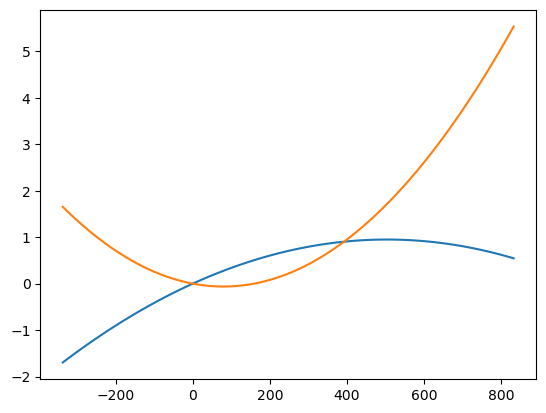

In [103]:
t_max = np.linspace(df['twsa_max'].min(),df['twsa_max'].max(),100)
max_coef = mod_max.coef()
me0 = t_max*max_coef['twsa_max']+(t_max**2)*max_coef['twsa_max_sq']
me1 = t_max*max_coef['twsa_max_lag1']+(t_max**2)*max_coef['twsa_max_sq_lag1']
plt.plot(t_max,me0)
plt.plot(t_max,me0+me1)

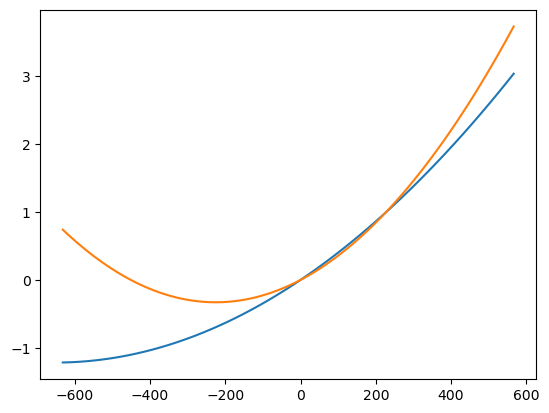

In [104]:
t_min = np.linspace(df['twsa_min'].min(),df['twsa_min'].max(),100)
min_coef = mod_min.coef()
me0 = t_min*min_coef['twsa_min']+(t_min**2)*min_coef['twsa_min_sq']
me1 = t_min*min_coef['twsa_min_lag1']+(t_min**2)*min_coef['twsa_min_sq_lag1']
plt.plot(t_min,me0)
plt.plot(t_min,me0+me1)

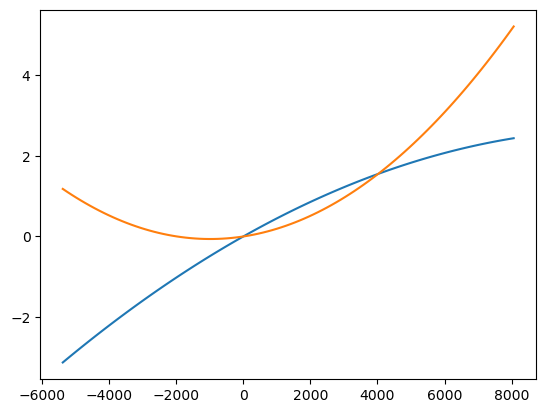

In [105]:
t_s = np.linspace(df['twsa_sum'].min(),df['twsa_sum'].max(),100)
sum_coef = mod_sum.coef()
me0 = t_s*sum_coef['twsa_sum']+(t_s**2)*sum_coef['twsa_sum_sq']
me1 = t_s*sum_coef['twsa_sum_lag1']+(t_s**2)*sum_coef['twsa_sum_sq_lag1']
plt.plot(t_s,me0)
plt.plot(t_s,me0+me1)

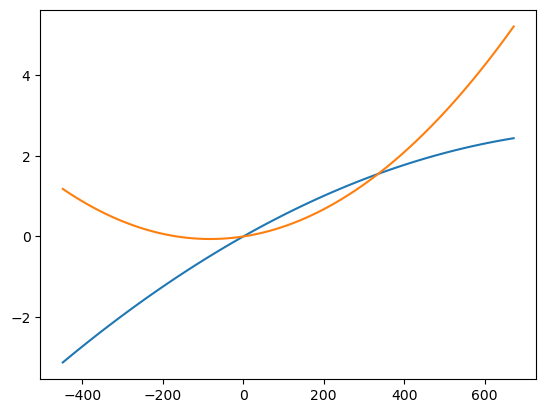

In [106]:
import matplotlib.pyplot as plt
t_m = np.linspace(df['twsa_mean'].min(),df['twsa_mean'].max(),100)
mean_coef = mod_mean.coef()
me0 = t_m*mean_coef['twsa_mean']+(t_m**2)*mean_coef['twsa_mean_sq']
me1 = t_m*mean_coef['twsa_mean_lag1']+(t_m**2)*mean_coef['twsa_mean_sq_lag1']
plt.plot(t_m,me0)
plt.plot(t_m,me0+me1)